In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import librosa
import librosa.feature
import glob
import os
import numpy as np
from utils import load_data
from models import simple_cnn
#from models import crnn
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from keras import backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Conv2D, Conv1D, MaxPooling2D, MaxPooling1D, Dense, Reshape, Dropout, SpatialDropout2D, LSTM, Input, BatchNormalization, Activation

Using TensorFlow backend.


## Data preprocessing

In [2]:
trainX, trainY, validationX, validationY, testX, testY = load_data(split_into_k_equal_parts=True, k=6)

In [3]:
#Transposing to (batch_size, time_dimension, features) for crnn
#trainX = trainX.transpose(0,2,1)
#validationX = validationX.transpose(0,2,1)
#testX = testX.transpose(0,2,1)

#Reshaping into (batch_size, height, width, channels) for cnn

trainX = trainX.reshape((trainX.shape[0], trainX.shape[1], trainX.shape[2], 1))
validationX = validationX.reshape((validationX.shape[0], validationX.shape[1], validationX.shape[2], 1))
testX = testX.reshape((testX.shape[0], testX.shape[1], testX.shape[2], 1))



In [4]:
print(trainX.shape)
print(trainY.shape)
print(validationX.shape)
print(testY.shape)

(90192, 128, 53, 1)
(90192, 5)
(10854, 128, 53, 1)
(10350, 5)


## Basic CNN

In [5]:
indim_x = trainX.shape[1]
indim_y = trainX.shape[2]
indim_x

128

In [6]:
model = simple_cnn((indim_x,indim_y), conv_layers=[16, 32,48], reg_rate=0.2)

In [7]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 51, 16)       160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 25, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 25, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 23, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 11, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 11, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 9, 48)         1

In [8]:
working_directory = os.path.dirname(os.getcwd())
checkpoint_filepath = os.path.join(working_directory, "Checkpoint")

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
model_earlyStopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    min_delta=0, 
    patience=10,        #stopping training after 10 not improved consecutive epochs 
    verbose=0, 
    mode='auto',
    baseline=None, 
    restore_best_weights=False)
history = model.fit(trainX, trainY, batch_size = 128, validation_data=(validationX, validationY), epochs=20, callbacks=[model_earlyStopping_callback])

Train on 90192 samples, validate on 10854 samples
Epoch 1/20
90192/90192 [==============================] - 21s 228us/sample - loss: 1.2969 - accuracy: 0.5500 - val_loss: 1.0291 - val_accuracy: 0.6059
Epoch 2/20
90192/90192 [==============================] - 16s 178us/sample - loss: 0.8739 - accuracy: 0.6689 - val_loss: 0.9274 - val_accuracy: 0.6645
Epoch 3/20
90192/90192 [==============================] - 16s 183us/sample - loss: 0.8087 - accuracy: 0.6958 - val_loss: 0.8943 - val_accuracy: 0.6727
Epoch 4/20
90192/90192 [==============================] - 16s 182us/sample - loss: 0.7759 - accuracy: 0.7067 - val_loss: 0.8765 - val_accuracy: 0.6699
Epoch 5/20
90192/90192 [==============================] - 16s 181us/sample - loss: 0.7563 - accuracy: 0.7145 - val_loss: 0.9201 - val_accuracy: 0.6552
Epoch 6/20
90192/90192 [==============================] - 16s 177us/sample - loss: 0.7383 - accuracy: 0.7204 - val_loss: 0.9293 - val_accuracy: 0.6655
Epoch 7/20
90192/90192 [====================

In [9]:
model.evaluate(testX, testY, verbose=2)

10350/1 - 1s - loss: 0.6239 - accuracy: 0.7370


[0.7304983701452541, 0.7370048]

In [10]:
Y_Predicted = model.predict_classes(testX, verbose=0)
testY.shape

(10350, 5)

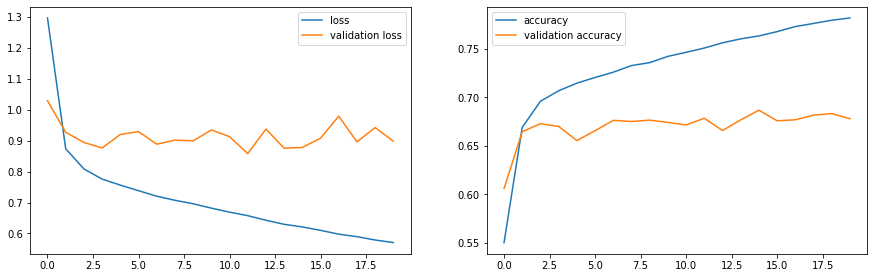

In [39]:
f = plt.figure(figsize=(15,10))
plt.subplot(221)
loss,  = plt.plot(history.history['loss'])
val_loss, = plt.plot(history.history['val_loss'])
plt.legend([loss, val_loss], ['loss', 'validation loss'])
plt.subplot(222)
acc,  = plt.plot(history.history['accuracy'])
val_acc,  = plt.plot(history.history['val_accuracy'])
plt.legend([loss, val_loss], ['accuracy', 'validation accuracy'])

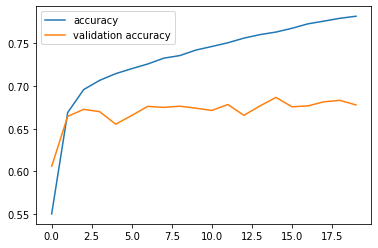

In [56]:
Y_True = []
for i in testY:
    Y_True.append(list(i).index(1))

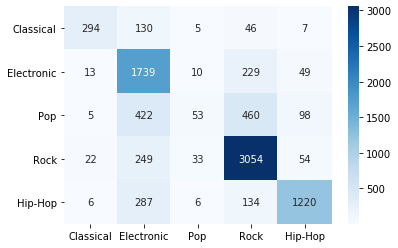

In [57]:
target_names = ['Classical', 'Electronic', 'Pop', 'Rock', 'Hip-Hop']
conf_matrix = pd.DataFrame(confusion_matrix(Y_True, Y_Predicted), index = target_names, columns = target_names)
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')


In [39]:
classification = pd.DataFrame(classification_report(Y_True, Y_Predicted,target_names=target_names, output_dict = True)).transpose()
classification

,precision,recall,f1-score,support
Classical,0.813411,0.578838,0.676364,482.000000
Electronic,0.629546,0.687255,0.657136,2040.000000
Pop,0.305085,0.208092,0.247423,1038.000000
Rock,0.770121,0.818875,0.793750,3412.000000
Hip-Hop,0.757417,0.787659,0.772242,1653.000000
accuracy,0.694841,0.694841,0.694841,0.694841
macro avg,0.655116,0.616144,0.629383,8625.000000
weighted avg,0.680891,0.694841,0.685006,8625.000000


In [96]:
classification.to_csv("results_cnn.csv")
conf_matrix.to_csv("conf_matrix_cnn.csv")

In [135]:
def crnn(input_shape, conv_layers, lstm_units,
               kernel_size=3, pool_size=2, reg_rate=0.2,
               hidden_dense=100
               ) -> Model:
    """ Creates cnn model with specified number of convolutional layers

    Parameters
    ----------
    input_shape : 2 integer tuple
        Shape of the input for first convolutional layer
    conv_layers : list or array
        Vector of filters for convolutional layers. The number of layers
        depends on the length of the vector
    lstm_units : int
    	Number of units in LSTM layer
    kernel_size : int
        Kernel size for convolutional layers
    pool_size : int
        Window size for pooling layers
    reg_rate: float
        Regularization rate
    num_classes : int
        Number of classes for classification problem. 
        Needed for output layer
        
    Returns
    -------
    keras.models.Model
        
    """

    model_input = Input((input_shape[0], input_shape[1], 1), name='input')
    layer = model_input
    for num_filters in conv_layers:
    # give name to the layers
	    layer = Conv2D(
	            filters=num_filters,
	            kernel_size=kernel_size
	        )(layer)
	    layer = BatchNormalization(momentum=0.9)(layer)
	    layer = Activation('relu')(layer)
	    layer = MaxPooling2D(pool_size)(layer)
	    layer = Dropout(reg_rate)(layer)
    layer = Reshape((input_shape[0], input_shape[1]))(layer)
    ## LSTM Layer
    layer = LSTM(lstm_units, return_sequences=False)(layer)
    layer = Dropout(reg_rate)(layer)
    
    ## Dense Layer
    layer = Dense(hidden_dense, activation='relu')(layer)
    layer = Dropout(reg_rate)(layer)
    
    ## Softmax Output
    layer = Dense(5)(layer)
    layer = Activation('softmax', name='output_realtime')(layer)
    model_output = layer
    model = Model(model_input, model_output)
    # model = Sequential()
    
        
    # model.add(Conv1D(conv_layers[0], kernel_size, activation='relu', input_shape=input_shape+(1,)))
    # model.add(MaxPooling1D(pool_size))
    # model.add(Dropout(reg_rate))
    # for index, filters in enumerate(conv_layers[1:]):
    #     model.add(Conv1D(filters, kernel_size, activation='relu'))
    #     model.add(MaxPooling1D(pool_size))
    #     model.add(Dropout(reg_rate))
    # model.add(Reshape())
    # model.add(LSTM(lstm_units, return_sequences=False))
    # model.add(Dropout(reg_rate))

    # #model.add(Flatten())
    # model.add(Dense(100, activation='relu'))
    # model.add(Dense(units=num_classes, activation='softmax'))
    
    return model

In [136]:
crnn_model = crnn((indim_x,indim_y), conv_layers=[16, 32, 48], lstm_units=48, reg_rate=0.25, hidden_dense=30)

In [137]:
crnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
crnn_model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 53, 128, 1)]      0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 51, 126, 16)       160       
_________________________________________________________________
batch_normalization_27 (Batc (None, 51, 126, 16)       64        
_________________________________________________________________
activation_27 (Activation)   (None, 51, 126, 16)       0         
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 25, 63, 16)        0         
_________________________________________________________________
dropout_39 (Dropout)         (None, 25, 63, 16)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 23, 61, 32)        4640

In [138]:

crnn_model.fit(trainX, trainY, batch_size = 128, validation_data=(validationX, validationY), epochs=15)

Train on 90192 samples, validate on 10854 samples
Epoch 1/15
  128/90192 [..............................] - ETA: 34:39

InvalidArgumentError:  Input to reshape is a tensor with 344064 values, but the requested shape has 868352
	 [[node model_5/reshape/Reshape (defined at C:\Users\Szalo\Miniconda3\envs\tensorflow\lib\site-packages\tensorflow_core\python\framework\ops.py:1751) ]] [Op:__inference_distributed_function_93044]

Function call stack:
distributed_function


AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'reshape'

In [91]:
type(trainX)

tensorflow.python.framework.ops.EagerTensor

In [112]:
(42,56)+(1,)

(42, 56, 1, 1)